### Whether the jitter of exposition might dramatically influence the reconstruction accuracy?

In [132]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
N = 16 # num of phase shifting steps
K = 10 # num of sine periods
a0 = 2 ** 12 # sine amplitude / 12bits image
k = 16 # num of points per sine wave

We can model exposition jitter as a Bernoulli random variable applied to the amplitude of a sine wave

In [146]:
def jitter( val : np.float32 ) -> np.array:   
    intensity_jitter = val * a0 * np.random.binomial( 1, 0.5, (N,) ) 
    intensity_jitter = np.expand_dims(intensity_jitter, axis=1)
    intensity_jitter = np.repeat(intensity_jitter, k*K, axis=1)
    
    return intensity_jitter

### 16-step Algorithm

In [143]:
# ideal phase values
phase0 = np.linspace(0, -2.0 * np.pi * K, k*K, endpoint=False)

# sine phase-shifted waves 
delta_phase = 2*np.pi/N
phase_arrays = np.fromfunction(lambda i, j: a0 * (0.5 + 0.5 * np.cos(j * 2.0 * np.pi/k + delta_phase * i)), ( N, k*K ), dtype=np.int32 )

cos_ = np.array([np.cos(i * 2.0 * np.pi / N) for i in range(N)], np.float32)
sin_ = np.array([np.sin(i * 2.0 * np.pi / N) for i in range(N)], np.float32)

In [144]:
def apply_jitter_and_reconstruct( jitter_val : float ) -> np.array:
    
    # applying amplitude jitter
    phase_arrays_jitter = phase_arrays - jitter(jitter_val)

    #let's reconstruct the phase
    phase = [np.arctan2(phase_arrays_jitter[:,i] @ sin_ , phase_arrays_jitter[:,i] @ cos_) for i in range(K*k)]
    phase = np.unwrap(phase)

    phase_error = phase - phase0

    #and plot the phase error
    _, ax = plt.subplots()
    ax.set_ylabel("phase error, rad")
    ax.plot( phase_error )
    
    return phase_error

Jitter 0.1% of Amplitude

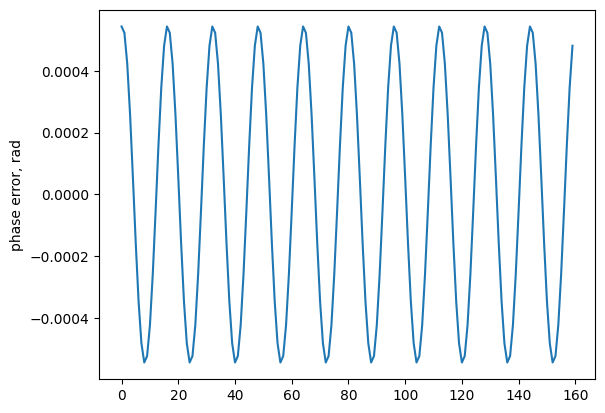

In [145]:
phase_error = apply_jitter_and_reconstruct(1.0e-3)

We can convert phase error to height error, using the following equation:

$Z = \dfrac{ \epsilon L }{ \epsilon + d }, \\[10pt]
\epsilon = \dfrac{ \Delta }{ 2 \pi } \dfrac{L}{f} T ,$ where

$L$ — distance from scanner to object,

$d$ — distance between camera and projector,

$f$ — projector focal length,

$\Delta$ — phase error

$T$ — period of a sine wave



### MLBS112 Device

In [126]:
# MLBS112 device

f_pr = 16.0 # projector focal length, mm
L = 1800 # distance to object, mm
d = 480 # distance between camera and projector, mm
pix = 10.8e-3 # size of projector pixel, mm

def convert_phase_to_z(phase_array : np.array) -> None:

    err = pix * k * L/f_pr * phase_array / ( 2 * np.pi ) 
    z_error = err * L / ( err + d )

    _, ax = plt.subplots()
    ax.set_ylabel("Z error, mm")
    ax.plot( z_error )


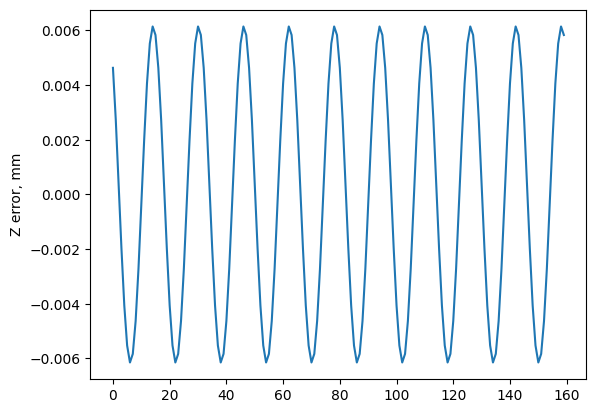

In [127]:
convert_phase_to_z(phase_error)

Jitter 1% of Amplitude

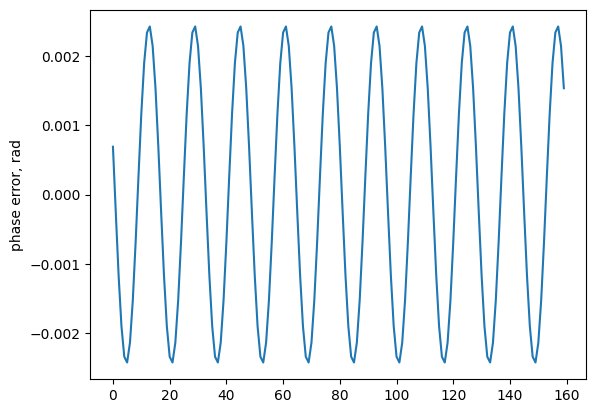

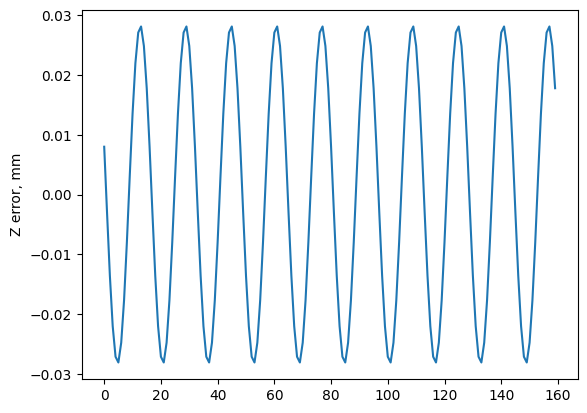

In [128]:
phase_error = apply_jitter_and_reconstruct(1.0e-2)
convert_phase_to_z(phase_error)

### 4-steps Algorithm
0.1% Jitter

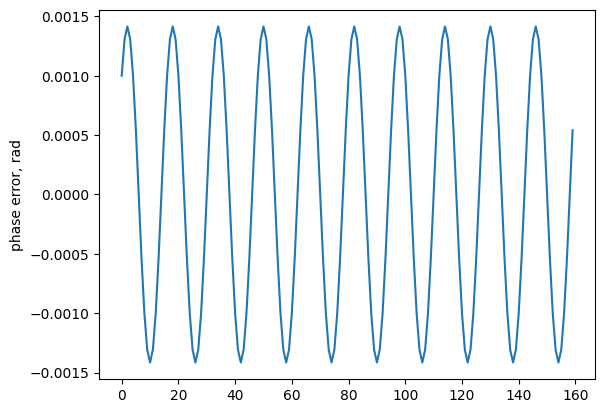

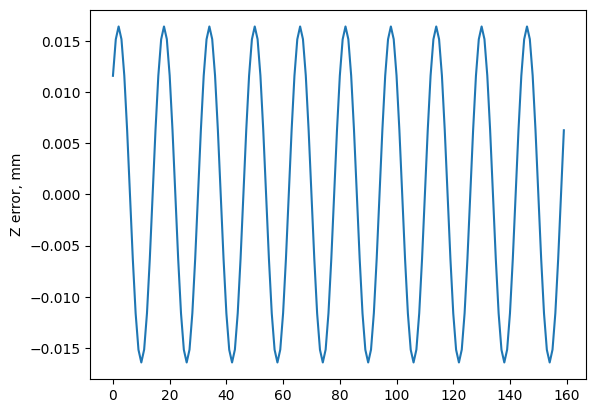

In [152]:
N = 4

delta_phase = 2*np.pi/N
phase_arrays = np.fromfunction(lambda i, j: a0 * (0.5 + 0.5 * np.cos(j * 2.0 * np.pi/k + delta_phase * i)), ( N, k*K ), dtype=np.int32 )

cos_ = np.array([np.cos(i * 2.0 * np.pi / N) for i in range(N)], np.float32)
sin_ = np.array([np.sin(i * 2.0 * np.pi / N) for i in range(N)], np.float32)

phase_error = apply_jitter_and_reconstruct(1.0e-3)
convert_phase_to_z(phase_error)

1% Jitter

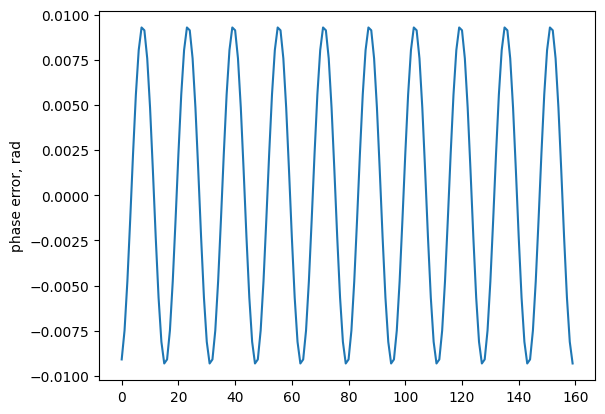

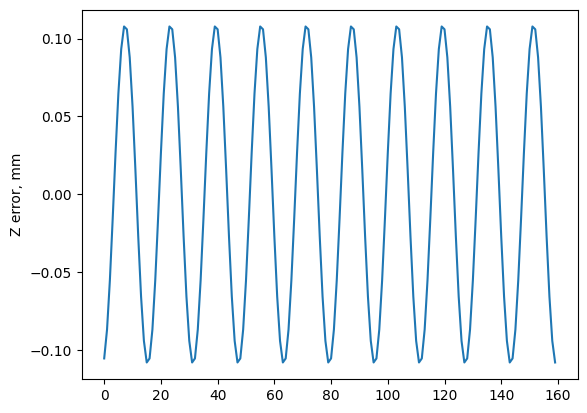

In [151]:
phase_error = apply_jitter_and_reconstruct(1.0e-2)
convert_phase_to_z(phase_error)

### Conclusions:

In experiments we observe the Z error about 0.5 mm, assuming jitter of 10 $\mu sec$ which results in 0.1% of amplitude modulation.

In this simulation we can conclude:

- for 16 steps algorithm jitter of 0.1% results in 2 $\mu m$ error
- for 16 steps algorithm jitter of 1% results in 30 $\mu m$ error 
- for 4 steps algorithm jitter of 0.1% results in 15 $\mu m$ error
- for 4 steps algorithm jitter of 1% results in 100 $\mu m$ error

So, observations disagree with theory by at least 2 orders of magnitude